## Imports, Classes, and Constants

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn.utils import shuffle
from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

RANDOM_SEED = 42

class StemCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemCountVectorizer, self).build_analyzer()
        
        return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])
    
mcu = pd.read_csv("./data/mcu.csv")

## Data Preprocessing

In [2]:
min_line_count = 150

is_main_character = mcu["character"].value_counts() > min_line_count
is_main_character = is_main_character.rename("is main character", axis=0)

main_character_rows = is_main_character[mcu["character"]]
main_character_rows = main_character_rows.reset_index(drop=True)

mcu_partial = mcu[main_character_rows]

pd.DataFrame(is_main_character)[is_main_character]

,is main character
TONY STARK,True
THOR,True
STEVE ROGERS,True
BRUCE BANNER,True
PETER QUILL,True
ROCKET,True
NATASHA,True
PEPPER POTTS,True
LOKI,True


In [3]:
y = mcu_partial["character"].to_numpy().astype(str)
X = mcu_partial["line"].to_numpy().astype(str)

X, y = shuffle(X, y, random_state=RANDOM_SEED)

X[0:10], y[0:10]

(array(['Got it.', 'And terrifying.', 'What’s the delta rate?',
        'This is beyond you, metal man. Loki will face Asgardian justice. ',
        'He was kidding.', 'Was he married?',
        'Is this about the Avengers?  Which I know nothing about.',
        'Oh, sure, okayyyy, Quill.', 'Can I ask a few back?',
        'Stark, are you seeing this? '], dtype='<U606'),
 array(['BRUCE BANNER', 'PEPPER POTTS', 'TONY STARK', 'THOR', 'NATASHA',
        'STEVE ROGERS', 'PEPPER POTTS', 'ROCKET', 'TONY STARK',
        'STEVE ROGERS'], dtype='<U12'))

## Models

In [4]:
cross_validator = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
score_method = "balanced_accuracy"

In [5]:
stem_count_vectorizer = StemCountVectorizer(binary=False)
tfidf_transformer = TfidfTransformer()
nb_classifier = MultinomialNB()

In [6]:
count_params = {'vect__stop_words': [None, stopwords.words('english')],
              'vect__ngram_range': [(1,1), (1,2)]}

tfidf_params = {'tfidf__norm': ['l1', 'l2'],
              'tfidf__use_idf': [True, False]}

nb_params = {'clf__alpha': [1e-1, 1e-2, 1e-3],
             'clf__fit_prior': [True, False]}

In [7]:
pipe13 = Pipeline([('vect', stem_count_vectorizer),
                  ('tfidf', tfidf_transformer),
                  ('clf', nb_classifier)])

parameters13 = {**count_params, **tfidf_params, **nb_params}

grid13 = GridSearchCV(pipe13, parameters13, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=3)

## Results

In [10]:
models = {"model 13": grid13}

cv_score_table = pd.DataFrame()

for name, model in models.items():
    results = cross_val_score(model, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1)
    cv_score_table.insert(len(cv_score_table.columns), name, results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

,model 13
fold,
0,0.261930
1,0.255685
2,0.233777
3,0.273962
4,0.278764
mean,0.260824
std,0.015834
max,0.278764


In [12]:
grid13.fit(X,y)
grid13.best_params_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 15.5min finished


{'clf__alpha': 0.01,
 'clf__fit_prior': False,
 'tfidf__norm': 'l2',
 'tfidf__use_idf': True,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [42]:
model13 = Pipeline([('vect', StemCountVectorizer(ngram_range=(1,2), stop_words=None, binary=False)),
                  ('tfidf', TfidfTransformer(norm='l2', use_idf=True)),
                  ('clf', MultinomialNB(alpha=0.01, fit_prior=False))])

## Confusion Matrix

balanced_accuracy: 0.9572496322941119


,plot legend,# of examples
0,TONY STARK,645
1,THOR,479
2,STEVE ROGERS,260
3,BRUCE BANNER,258
4,PETER QUILL,228
5,ROCKET,198
6,NATASHA,179
7,PEPPER POTTS,172
8,LOKI,164


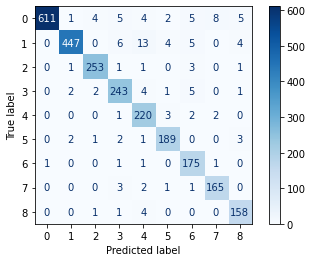

In [33]:
model13.fit(X,y)
yhat = model13.predict(X)

print("balanced_accuracy:", metrics.balanced_accuracy_score(y, yhat))

main_characters = pd.DataFrame(is_main_character)[is_main_character].index.values

metrics.plot_confusion_matrix(model13, X, y, labels = main_characters, display_labels = np.arange(9),
                             values_format = 'd', cmap=plt.cm.Blues)

line_counts = pd.DataFrame(mcu_partial["character"].value_counts())["character"]
table = pd.DataFrame({"plot legend": main_characters, "# of examples": line_counts})
table.reset_index(drop=True, inplace=True)

table

## Learning Curve

In [36]:
def plot_learning_curve(estimator, title, X, y, axes=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, verbose=3)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return

[learning_curve] Training set sizes: [ 206  671 1136 1601 2066]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   40.8s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:  1.1min remaining:   32.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.5min finished


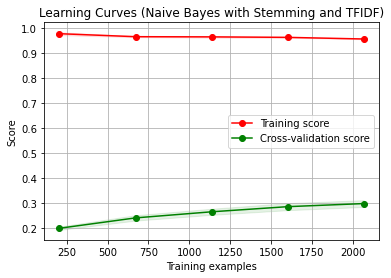

In [37]:
title = "Learning Curves (Naive Bayes with Stemming and TFIDF)"

plot_learning_curve(model13, title, X, y, cv=cross_validator)

## Export Model

In [45]:
model13.fit(X,y)
dump(model13, './front_end/production_model.joblib')

['./front_end/production_model.joblib']